# Intro to Forecasting - Creating Weather Forecasting Models

## Trevor Rowland - 3/27/25

This notebook aims to create simple forecasting models for day-ahead and week-ahead weather, along with statistics to measure forecast accuracy and biases.

## 1. Importing Packages and Creating Data

We will start by creating a `RegionWeather` object for each region, then get to work on the forecasting techniques.

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from backend.regionweather import RegionWeather

region_data = {
    'US-FLA-FMPP': {'lat': 28.525581, 'lon': -81.536775, 'alt': 0},
    'US-FLA-FPC': {'lat': 28.996695, 'lon': -82.886613, 'alt': 0},
    'US-FLA-FPL': {'lat': 27.917488, 'lon': -81.450970, 'alt': 0},
    'US-FLA-GVL': {'lat': 29.619310, 'lon': -82.328732, 'alt': 0},
    'US-FLA-HST': {'lat': 25.456904, 'lon': -80.588092, 'alt': 0},
    'US-FLA-JEA': {'lat': 30.390902, 'lon': -83.679837, 'alt': 0},
    'US-FLA-SEC': {'lat': 28.805983, 'lon': -82.306291, 'alt': 0},
    'US-FLA-TAL': {'lat': 30.437174, 'lon': -84.248042, 'alt': 0},
    'US-FLA-TEC': {'lat': 27.959413, 'lon': -82.144821, 'alt': 0}
}

In [80]:
rw1 = RegionWeather('US-FLA-FMPP', region_data['US-FLA-FMPP']['lat'], region_data['US-FLA-FMPP']['lon'], region_data['US-FLA-FMPP']['alt'], dt.datetime(2024, 1, 1), dt.datetime(2024, 12, 31)).to_dict()

Fetching Hourly Object...
Hourly Object Fetched!
Fetching Hourly Data from Object...
Hourly Object Fetched!
Hourly Data Cleaned!
Fetching Daily Data...
Daily Data Fetched!
Fetching Weekly Data...
Weekly Data Aggregated and Fetched!
Fetching Monthly Data...
Fetching Daily Data...
Monthly Data Fetched!
15 Minute Data Interpolated!


In [81]:
rw1['df_hourly'].head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2024-01-01 00:00:00,14.2,8.8,70.0,0.0,NaN,3.0,9.0,NaN,1024.0,NaN,1.0
2024-01-01 01:00:00,14.6,9.2,70.0,0.0,NaN,0.0,0.0,NaN,1024.1,NaN,1.0
2024-01-01 02:00:00,12.4,8.5,77.0,0.0,NaN,0.0,0.0,NaN,1024.2,NaN,1.0
2024-01-01 03:00:00,11.3,8.2,81.0,0.0,NaN,289.0,10.1,NaN,1024.4,NaN,3.0
2024-01-01 04:00:00,11.9,8.6,80.0,0.0,NaN,265.0,0.0,NaN,1024.4,NaN,5.0


## 2. Intro to Forecasting Models

For the project, we need to forecast a day-ahead look at the weather, along with a weekly forecast. I asked Claude to give me some summary information before diving deeper myself. It recommended I use an ARIMA model for the day-ahead forecast, as it is good for short-term predictions. For the weekly forecast, techniques like ...



### a. ARIMA Models

###### Source: [How to build ARIMA models in Python for time series forecasting](<https://www.youtube.com/watch?v=-aCF0_wfVwY>)

#### What is ARIMA?

Auto-Regressive Integrated Moving Average (ARIMA) is a general class of statistical models for time series analysis forecasting

ARIMA uses a time series' past values and/or forecast errors to predict future values, making it reliant on historical data.

ARIMA has one important assumption: **The time series must be stationary**. This means that the time series must first be made stationary (mean = 0, constant variance).

ARIMA is a general class of models because it contains 3 components: AR, I, and MA that are represented by parameters p, d, and q.

p, d, and q are non-negative integer values indicating which specific ARIMA model is used. 

##### ARIMA(p,d,q)

- AR (Auto-regressive): The time series is linearly regressed on its own past values

$$
\begin{align*}
\text{p: the number of past values included in the AR model} \\

y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_3 y_{t-p} + \epsilon_t \\
\end{align*}
$$

- I (Integrated): If not stationary, the time series can be differenced to become stationary. I.e., compute the differences between consecutive observations

$$
\begin{align*}
\text{d: the number of times the time series is differenced} \\
\nabla y_t = y_t - y_{t-1}
\end{align*}
$$

- MA (Moving Average): The time series is 'regressed' on the past forecast errors

$$
\begin{align*}
\text{q: the number of past forecast errors included in the MA model} \\
y_t = c + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q} \\
\end{align*}
$$

Add more if you need to here...

##### ARIMA(p,d,q) Full Equation

$$
\begin{align*}
\nabla y_t = c + \phi_1 \nabla y_{t-1} + ... + \phi_p \nabla y_{t-1p} + \epsilon_t + \theta_1 \epsilon_{t-1}... + \theta_q \epsilon_{t-q}
\end{align*}
$$

- $\text{AR: }ARIMA(p, 0, 0) = AR(p)$, AR-model only
- $\text{MA: }ARIMA(0, 0, q) = MA(q)$, MA-model only
- $\text{ARMA: }ARIMA(p, 0, q)$, combination of AR-MA without differencing
- $ARIMA$, the full model including differencing

Now we can cover the example in python to better understand what these models do.


### a. Python Implementation

First we will select a single variable to forecast. Let's go with `temp`, or the temperature of the region.

In [82]:
df = rw1['df_hourly']['temp'].reset_index(drop=True)

df.head()

0    14.2
1    14.6
2    12.4
3    11.3
4    11.9
Name: temp, dtype: float64

Now we can plot the dataframe to see what the time series looks like.

<Axes: >

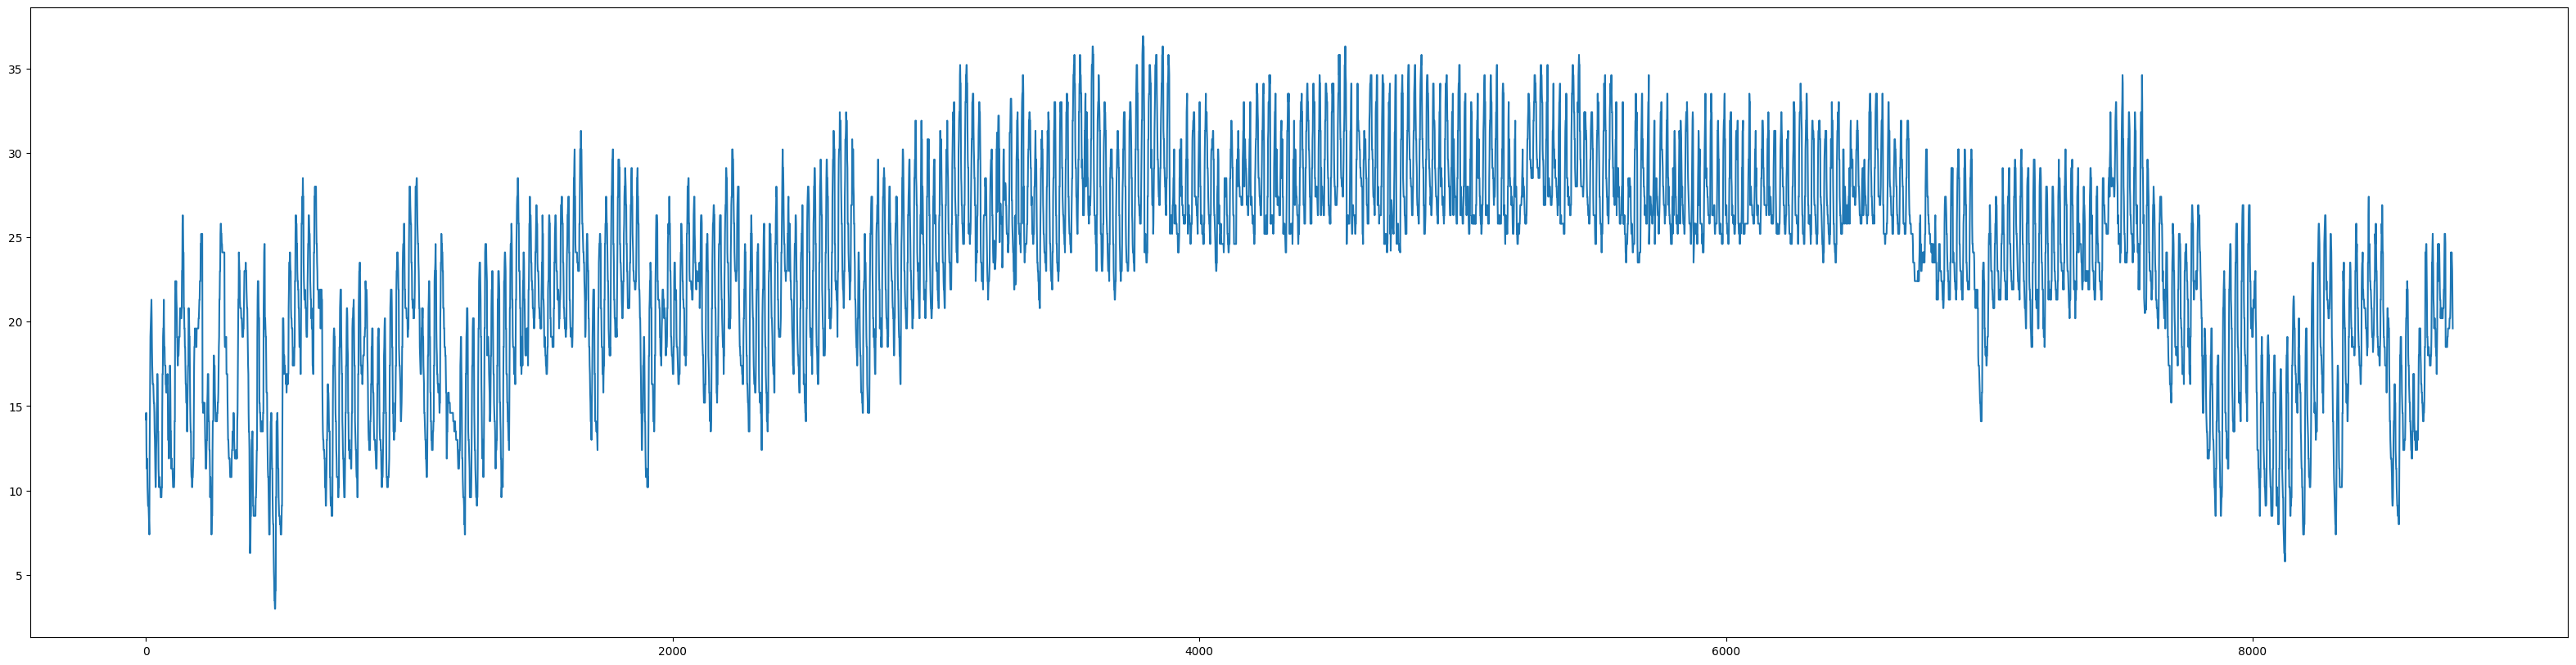

In [83]:
df.plot(figsize=(40, 10))

From the data, we see a time series that is not stationary. It does not look like it has a constant variance or mean, due to the uncentered data. Let's standardize by taking the logarithm of the series.

<Axes: >

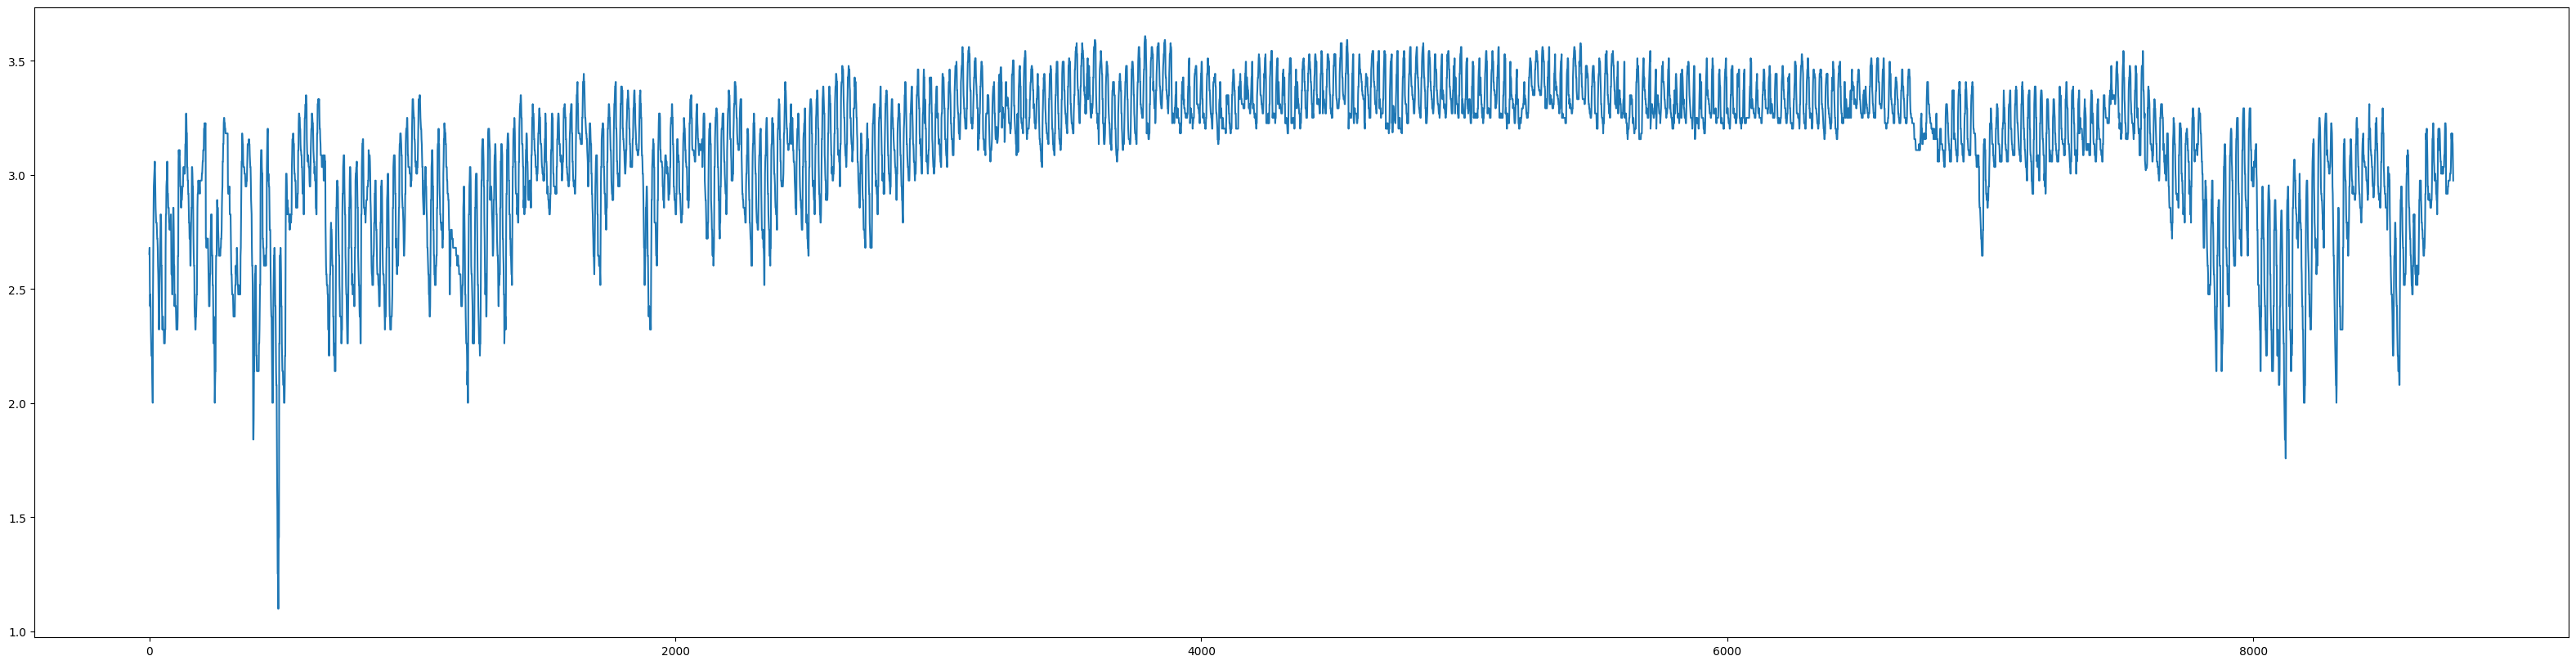

In [84]:
df_log = np.log(df)
df_log.plot(figsize=(40, 10))

Now it is centered around a single mean, but the variance still looks off. Let's create a test-train dataset of the last 30 days, then make sure the series is stationary using an ACF and PACF plot.

In [85]:
# Get last 30 observations
mask = (df.index < len(df)-90)
df_log_train = df_log[mask]
df_log_test = df_log[~mask]

#### i. Checking Stationarity: ACF and PACF plots

- **ACF**, or autocorrelation function, is the correlation of the time series with its lags ($y_t$ and $y_{t-k}$ for $k=1,2,\dots$)
  - It measures the linear relationships between lag values of the time series
  - Straightforward to measure but relationships are often more complicated in reality.
  - *Question*: Assume $y_t$ and $y_{t-1}$ are correlated, and $y_{t-1}$ and $y_{t-2}$ are correlated. How can we measure if there is new information in $y_{t-2}$ to predict the next observation, $y_t$, besides their relationships with $y_{t-1}$?
    - This is why we need the PACF plot

- **PACF**, or partial autocorrelation function, is the partial correlation of the time series with its lags, after removing the effects of lower-order-lags between them.
  - e.g. the partial autocorrelation of $y_t$ and $y_{t-k}$ is the correlation **that is not explained** by their relationships with the lags $y_{t-1}, y_{t-2}, \dots, y_{t-k+1}$. In other words, it is a correlation of $y_t$ and $y_{t-k}$ that essentially is looking at just those two observations in isolation.

Now let's look at the ACF and PACF plots of the time series.

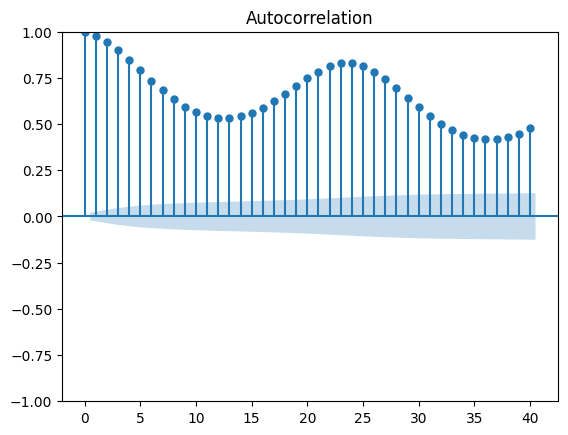

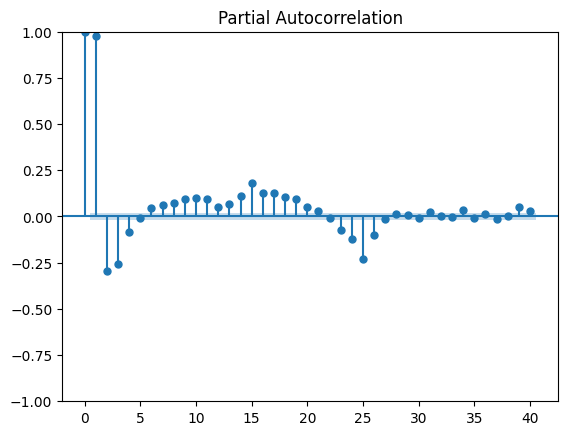

In [86]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_orig = plot_acf(df_log_train)
pacf_orig = plot_pacf(df_log_train)

Not sure how to interpret these...

The tutorial mentions random walks, and the charts here seem to follow the same intuition outlined in the video. Let's keep going and do the ADF test to check for stationarity with a statistical test.

#### ii. Checking Stationarity: Augmented Dickey-Fuller Test

Another way to test stationarity is with the Augmented Dickey-Fuller (ADF) test. It has the hypotheses:

$$
\begin{align*}
H_0 &: \text{There is a unit root (TS is non-stationary)}
H_A &: \text{There is no unit root}
\end{align*}
$$

$H_A$ is not covered in the video... check the [wikipedia page](<https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test>) and [statsmodels docs](<https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html>)

Let's apply the test now:

In [87]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df_log_train)

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -6.068690623418083
p-value: 1.1649227802831442e-07


Because the p-value is significantly high, we fail to reject the null hypothesis, and cannot reject that there is a unit root. This means the time series is non-stationary and must be transformed.

### Making the Time Series Stationary

We can transform the time series into a stationary time series using differencing.

<Axes: >

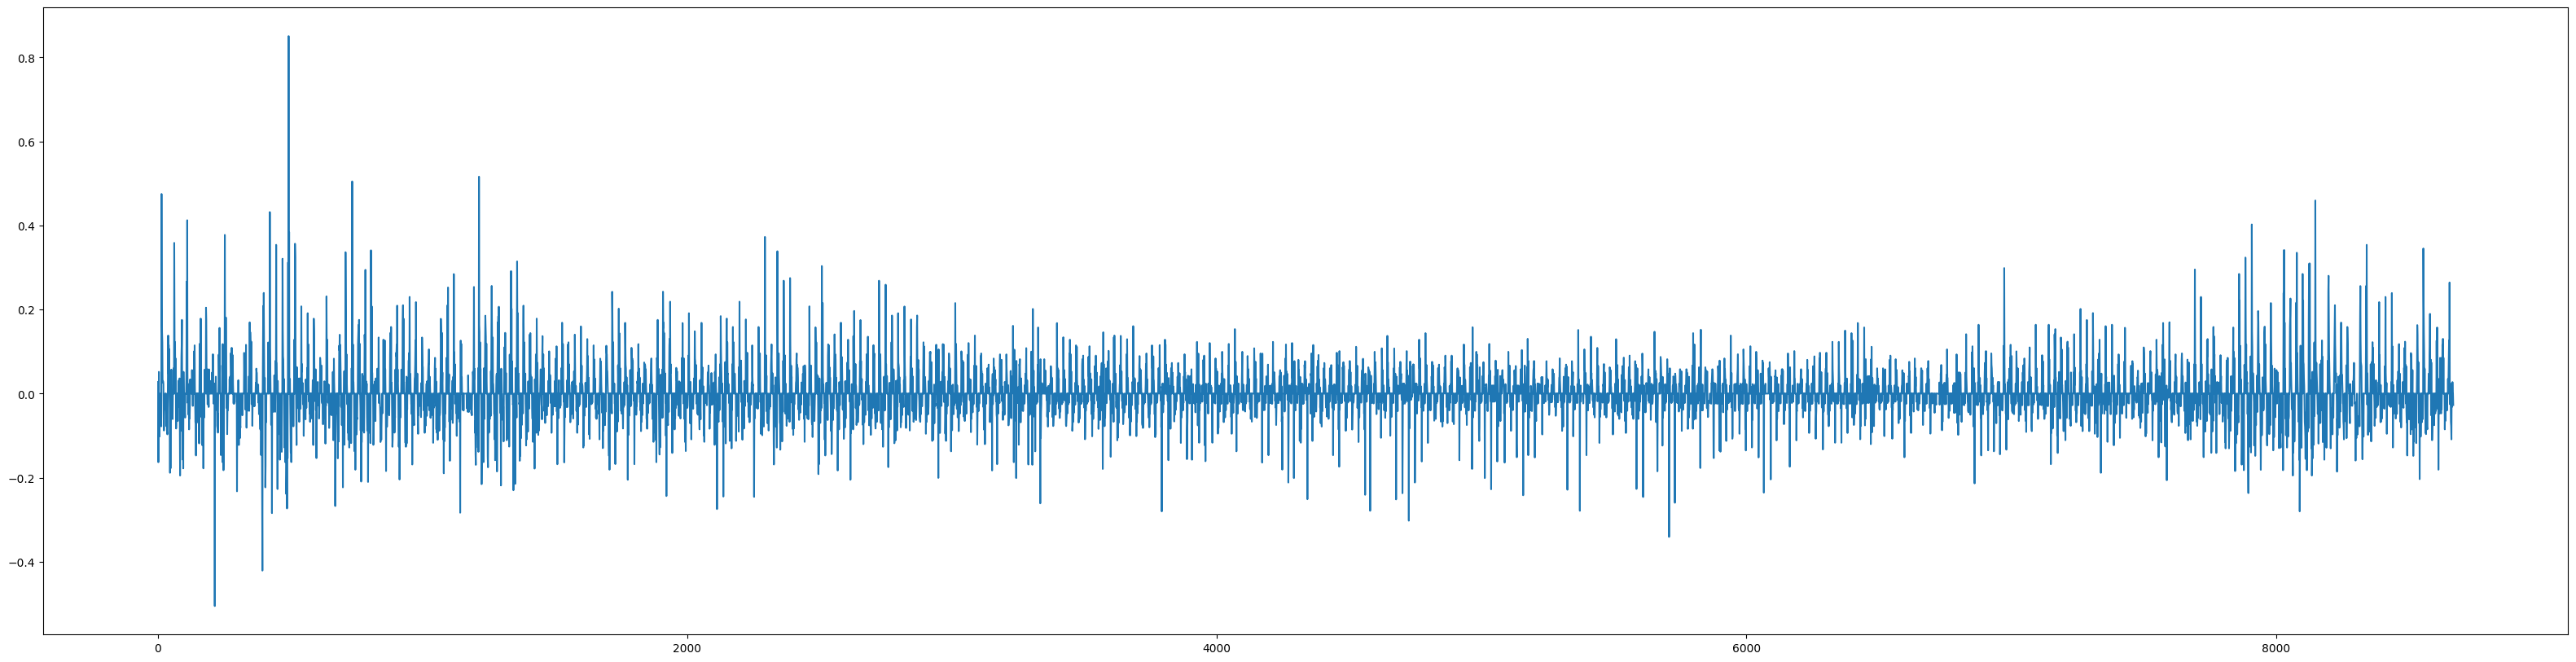

In [88]:
df_log_diff = df_log_train.diff()
df_log_diff.plot(figsize=(40,10))

Now the time series looks much more stationary. We can re-run the ACF/PACF plots and ADF test to see what changed.

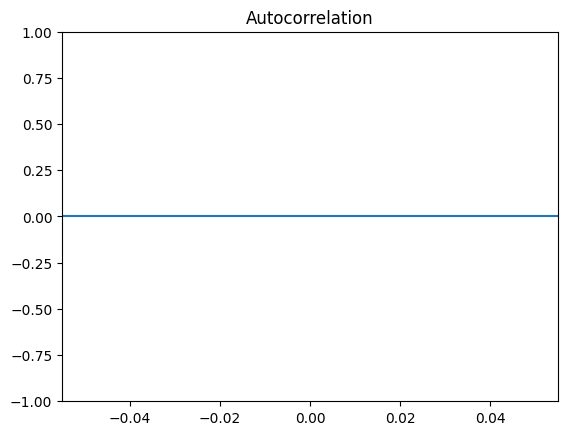

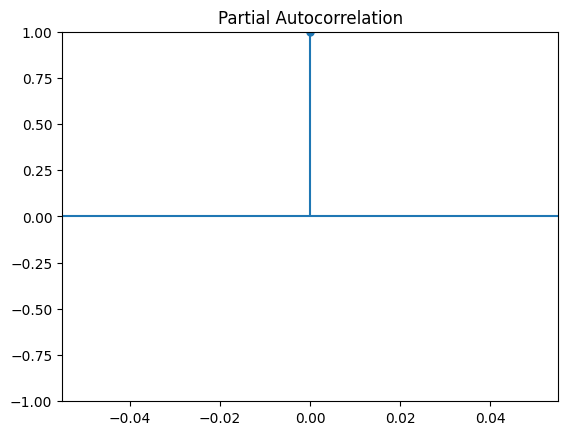

In [89]:
acf_diff = plot_acf(df_log_diff)
pacf_diff = plot_pacf(df_log_diff)


In [90]:
adf_test_diff = adfuller(df_log_diff.dropna())

print(f'ADF Statistic: {adf_test_diff[0]}')
print(f'p-value: {adf_test_diff[1]}')

ADF Statistic: -16.973447393797645
p-value: 9.12290183929174e-30


Now we have a p-value that is statistically significant enough to reject the null hypothesis, indicating stationarity.

This means that in our function $ARIMA(p,d,q)$ we can set $d=1$, giving us $ARIMA(p,1,q)$.

The next step is determining ARIMA parameters $p,q$.

We will again use the ACF/PACF plots. From the first difference plots, we can find out what the values are from the following rule of thumb:

- If the PACF plot has a significant spike at lag p, but not beyond; and the ACF plot decays more gradually, this may suggest an $ARIMA(p,d,0)$ model.

- If the ACF plot has a significant spike at lag q, but not beyond; the PACF plot decays more gradually. This may suggest an $ARIMA(0,d,q)$ model.

Typically we focus on either AR or MA but not both.

From the plots, we see a massive spike at $p=0$ and nowhere else in the PACF plot, and the ACF plot indicates no decay or increasing steps, so I am guessing here that it is an ARIMA(p,d,0) model?

Because we can't find a $p$ parameter in the ACF plot, we're just going to stick with what is used in the video, $p=2$, giving us an $ARIMA(2,1,0)$ model. **GO BACK AND FIX LATER!!!**

Now we can create the model using `statsmodels`.

In [91]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_log_diff, order=(2,1,0))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                 8671
Model:                 ARIMA(2, 1, 0)   Log Likelihood               11624.487
Date:                Thu, 27 Mar 2025   AIC                         -23242.975
Time:                        23:06:29   BIC                         -23221.772
Sample:                             0   HQIC                        -23235.746
                               - 8671                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6201      0.007    -90.684      0.000      -0.633      -0.607
ar.L2         -0.2197      0.007    -31.710      0.000      -0.233      -0.206
sigma2         0.0040   2.65e-05    150.643      0.0

Now we can use the model to create predictions, and evaluate the models with its residuals. When a model is good, the residuals should look like white noise. You can use the ACF and PACF plots again to evaluate the residuals.

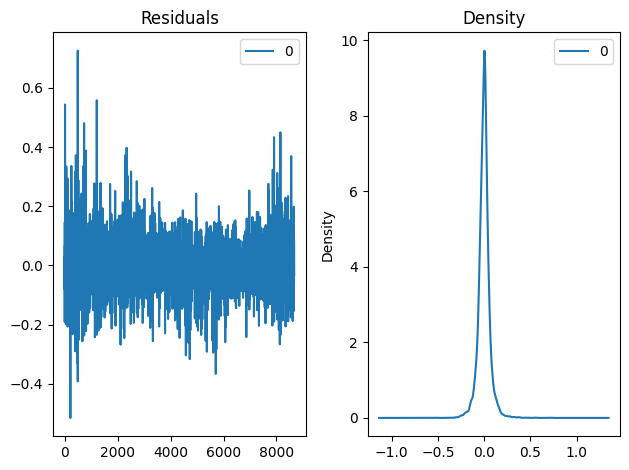

In [92]:
import matplotlib.pyplot as plt

# get residuals
residuals = pd.DataFrame(model_fit.resid[1:])

fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.tight_layout()
plt.show()


Now we can check the residuals and their density. The residuals chart looks very noisy, and the density chart looks *kinda* normal. I know I didn't do a great job with model selection, but these are OK results for now. Ideally, the density should look as close to normally distributed as possible.

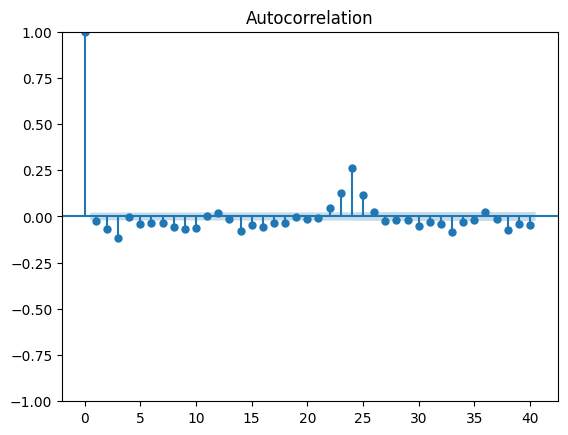

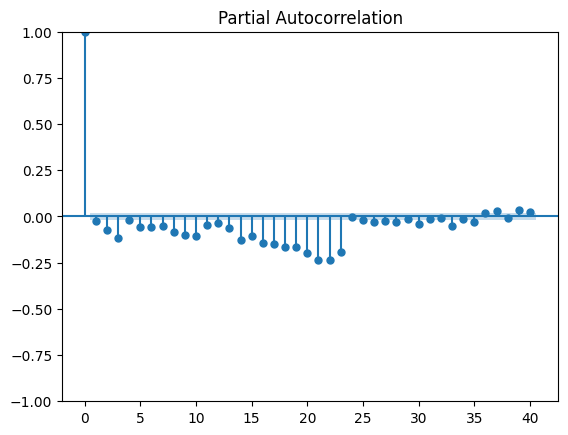

In [93]:
res_acf = plot_acf(residuals)
res_pacf = plot_pacf(residuals)

If both plots (mostly) have points (mostly) within the blue rectangle, we can assume the residuals are close to white noise.

We do not have this, but the tutorial does not mention what else to do when that is not the case, so let's move on.

We can now start forecasting!

<Axes: >

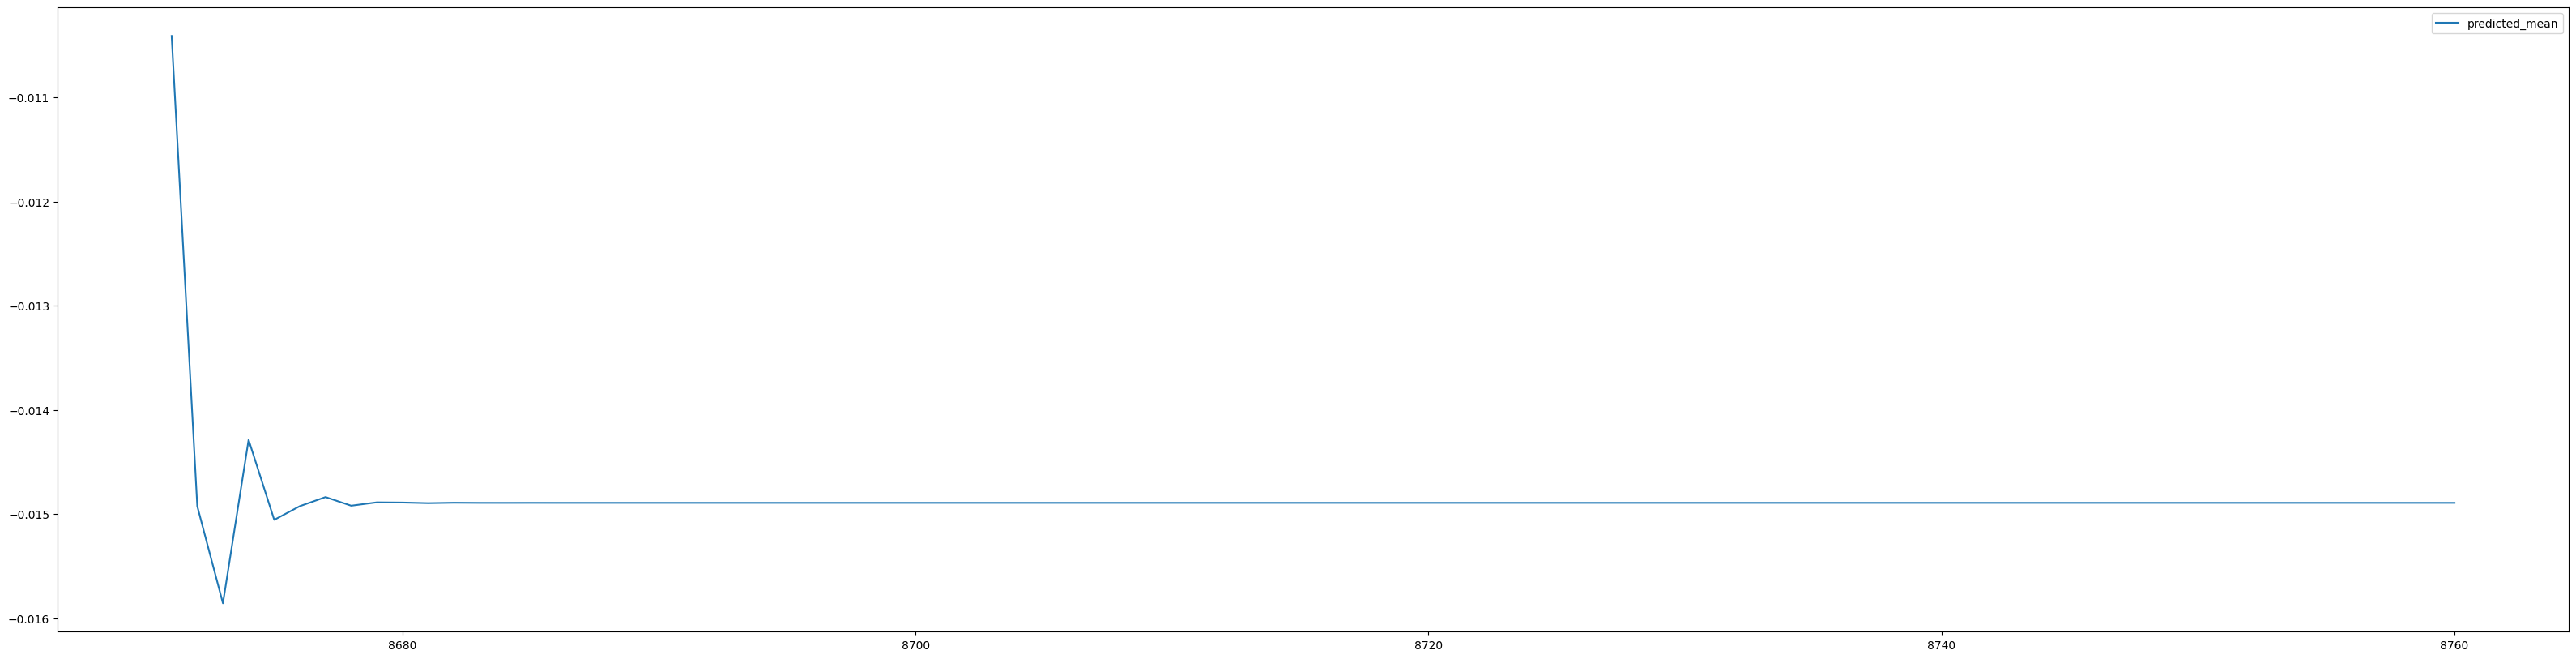

In [104]:
forecast_test = model_fit.forecast(len(df_log_test))
forecast_test.head()

df2 = pd.concat([df, forecast_test], axis=1)
df2.plot(figsize=(40,10))

Ok now we've lost the plot XD

I'm stuck.